In [583]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV 
from sklearn import gaussian_process
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import datetime
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier as DTC
plt.style.use('ggplot')

%matplotlib inline


In [584]:
s_2015 = pd.read_csv("data/input_2015.csv")
s_2016 = pd.read_csv("data/input_2016.csv")
citi = pd.read_csv("data/city_charac.csv")

In [585]:
citi["geo_location"] = citi["geo_location"].apply(lambda x: x.lower())

In [586]:
char_dict = citi.drop(["Unnamed: 0", "lat", 
           "game_center", 
           "lon", "geometry"], axis=1).set_index("geo_location") \
           .T.to_dict("list")

In [587]:
for key in char_dict:
    char_dict[key][0] = float(char_dict[key][0].replace(",", ""))
    char_dict[key][2] = float(char_dict[key][2].replace(",", ""))
    char_dict[key][3] = float(char_dict[key][3].replace(",", ""))

In [588]:
def process(data):  
    data = data.drop("Unnamed: 0", axis = 1)
    data = data.reset_index(drop = 1)
    data["date"] = pd.to_datetime(data["date"])
    data["mon"] = data["date"].apply(lambda x: x.month)
    data["day"] = data["date"].apply(lambda x: x.day)
    data["time"] = data["date"].apply(lambda x: x.hour)
    data["dow"] = data["date"].dt.dayofweek
    data["night"] = data["time"].apply(lambda x: 1 if x >= 19 else 0)
    data["weekday"] = data["dow"].apply(lambda x: 1 if (x>=0) & (x<=4) else 0)
    data["April"] = data["date"].apply(lambda x: 1 if x.month == 4 else 0)
    data["May"] = data["date"].apply(lambda x: 1 if x.month == 5 else 0)
    data["June"] = data["date"].apply(lambda x: 1 if x.month == 6 else 0)
    data["July"] = data["date"].apply(lambda x: 1 if x.month == 7 else 0)
    data["August"] = data["date"].apply(lambda x: 1 if x.month == 8 else 0)
    data["September"] = data["date"].apply(lambda x: 1 if x.month == 9 else 0)
    data["December"] = data["date"].apply(lambda x: 1 if x.month == 12 else 0)
    data["January"] = data["date"].apply(lambda x: 1 if x.month == 1 else 0)
    #data["visit_code"] = data["guest"].apply(lambda x: refer[x])
    #data["home_code"] = data["home"].apply(lambda x: refer[x])
    
    data["attendace_ratio"] = data.attendance / data.capacity
    return data

In [589]:
train = process(s_2015)
test = process(s_2016)

In [590]:
train = train[train["date"] >= datetime.date(2015, 10, 27)]
test = test[test["date"] >= datetime.date(2016, 10, 25)]

In [591]:
refer = dict(zip(pd.concat([train["home"], train["guest"],
                           test["home"], test["home"]]), 
               pd.Categorical(pd.concat([train["home"], train["guest"],
                           test["home"], test["home"]])).codes)) ## team code
pos = dict(zip(pd.concat([s_2015["game_center"], s_2016["game_center"]]), 
               pd.Categorical(pd.concat([s_2015["game_center"], s_2016["game_center"]])).codes))

In [592]:
def trans_label(data):
    data["pos"] = data["game_center"].apply(lambda x: pos[x])
    data["visit_code"] = data["guest"].apply(lambda x: refer[x])
    data["home_code"] = data["home"].apply(lambda x: refer[x])
    return data

In [593]:
train = trans_label(train)
test = trans_label(test)

In [614]:
Xnames = ['capacity', 'streak_home', 'streak_guest', 'mon',
       'day', 'time', 'dow', 'night', 'weekday', 'April', 'May', 'June',
       'July', 'August', 'September', 'home_code', 'visit_code', 
       "popu", "land_miles", "density", "income", "January", "December"]

In [615]:
def merge_char(data):
    data["popu"] = data["geo_location"].apply(lambda x: char_dict[x.lower()][0])
    data["land_miles"] = data["geo_location"].apply(lambda x: char_dict[x.lower()][1])
    data["density"] = data["geo_location"].apply(lambda x: char_dict[x.lower()][2])
    data["income"] = data["geo_location"].apply(lambda x: char_dict[x.lower()][3])
    return data

In [616]:
train = merge_char(train)
test = merge_char(test)

In [618]:
train["attendace_ratio"].to_csv("attance.csv")

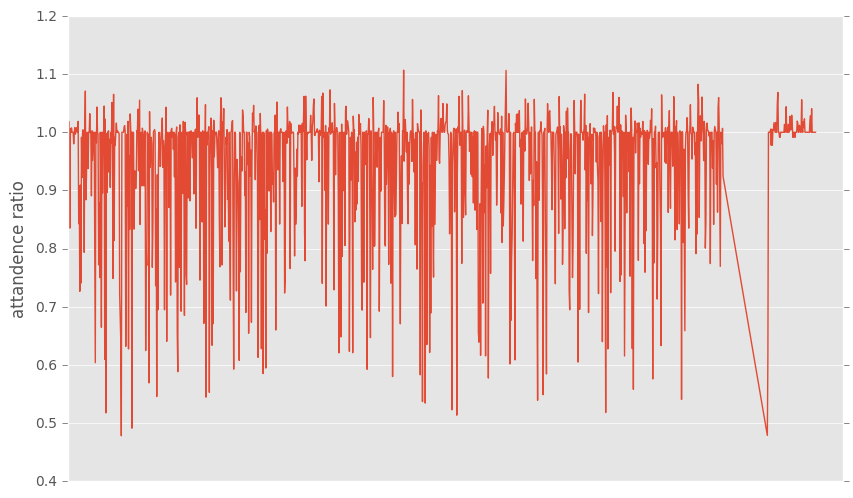

In [619]:
plt.figure(figsize = (10, 6))
plt.plot(train["attendace_ratio"])
plt.xticks([])
plt.ylabel("attandence ratio")
plt.savefig("ratio_plot.png", dpi=600)

In [620]:
(y_train > 0.9).sum()/len(y_train)

0.77672955974842772

In [621]:
Xtrain = train[Xnames]
Xtest = test[Xnames]
y_train = train["attendace_ratio"].copy()
y_test = test["attendace_ratio"].copy()

In [600]:
train.columns

Index(['Unnamed: 0.1', 'date', 'game_center', 'geo_location', 'attendance',
       'capacity', 'home', 'guest', 'streak_home', 'streak_guest', 'mon',
       'day', 'time', 'dow', 'night', 'weekday', 'April', 'May', 'June',
       'July', 'August', 'September', 'December', 'January', 'attendace_ratio',
       'pos', 'visit_code', 'home_code', 'popu', 'land_miles', 'density',
       'income'],
      dtype='object')

In [622]:
def make_class(data):
    data[data >= 0.9] = 1
    data[data < 0.9] = 0
    return data

In [623]:
y_train = make_class(y_train)
y_test = make_class(y_test)

#### Random forest trees

In [624]:
rfc_diff = RandomForestClassifier(max_depth=10, n_estimators=150)
rfc_diff.fit(Xtrain, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [625]:
rfc = RandomForestClassifier()
params = {
    "max_depth":range(10, 200, 10),
    "max_features":["auto", "sqrt", "log2"],
    "n_estimators":range(100, 1000, 50),
}
cv_rf = GridSearchCV(estimator=rfc, param_grid=params,
                     scoring="roc_auc", n_jobs = -1, cv=5, verbose=5)
cv_rf.fit(Xtrain, y_train)

Fitting 5 folds for each of 1026 candidates, totalling 5130 fits
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV] max_depth=10, max_features=auto, n_estimators=150 ...............
[CV] max_depth=10, max_features=auto, n_estimators=150 ...............
[CV] max_depth=10, max_features=auto, n_estimators=150 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=100, score=0.946039, total=   0.4s
[CV]  max_depth=10, max_features=auto, n_estimators=100, score=0.947900, total=   0.4s
[CV] max_depth=10, max_features=auto, n_estimators=150 ...............
[CV] max_depth=10, max_features=auto, n_estimators=150 ...............
[CV]  max_depth=10, max_features=auto, n_estimators

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s


[CV]  max_depth=10, max_features=auto, n_estimators=150, score=0.946305, total=   0.6s
[CV]  max_depth=10, max_features=auto, n_estimators=150, score=0.948609, total=   0.6s
[CV]  max_depth=10, max_features=auto, n_estimators=150, score=0.911395, total=   0.6s
[CV] max_depth=10, max_features=auto, n_estimators=200 ...............
[CV] max_depth=10, max_features=auto, n_estimators=200 ...............
[CV] max_depth=10, max_features=auto, n_estimators=250 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=150, score=0.975344, total=   0.6s
[CV]  max_depth=10, max_features=auto, n_estimators=150, score=0.951732, total=   0.6s
[CV] max_depth=10, max_features=auto, n_estimators=250 ...............
[CV] max_depth=10, max_features=auto, n_estimators=250 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=200, score=0.949318, total=   0.8s
[CV]  max_depth=10, max_features=auto, n_estimators=200, score=0.914496, total=   0.7s
[CV] max_depth=10, max_features=auto

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.7s


[CV]  max_depth=10, max_features=auto, n_estimators=650, score=0.950292, total=   2.2s
[CV] max_depth=10, max_features=auto, n_estimators=700 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=650, score=0.915648, total=   2.2s
[CV] max_depth=10, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=650, score=0.948259, total=   2.2s
[CV] max_depth=10, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=650, score=0.976160, total=   2.1s
[CV] max_depth=10, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=700, score=0.947634, total=   2.4s
[CV] max_depth=10, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=700, score=0.951090, total=   2.1s
[CV] max_depth=10, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   31.6s


[CV]  max_depth=10, max_features=sqrt, n_estimators=650, score=0.950824, total=   2.0s
[CV] max_depth=10, max_features=sqrt, n_estimators=700 ...............
[CV]  max_depth=10, max_features=sqrt, n_estimators=650, score=0.914053, total=   2.0s
[CV] max_depth=10, max_features=sqrt, n_estimators=750 ...............
[CV]  max_depth=10, max_features=sqrt, n_estimators=650, score=0.946122, total=   2.0s
[CV] max_depth=10, max_features=sqrt, n_estimators=750 ...............
[CV]  max_depth=10, max_features=sqrt, n_estimators=650, score=0.974529, total=   2.0s
[CV] max_depth=10, max_features=sqrt, n_estimators=750 ...............
[CV]  max_depth=10, max_features=sqrt, n_estimators=700, score=0.948343, total=   2.1s
[CV] max_depth=10, max_features=sqrt, n_estimators=750 ...............
[CV]  max_depth=10, max_features=sqrt, n_estimators=700, score=0.952330, total=   2.1s
[CV] max_depth=10, max_features=sqrt, n_estimators=750 ...............
[CV]  max_depth=10, max_features=sqrt, n_estimators=

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.0min


[CV] max_depth=20, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=10, max_features=log2, n_estimators=950, score=0.950470, total=   3.0s
[CV] max_depth=20, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=20, max_features=auto, n_estimators=150, score=0.914629, total=   0.5s
[CV] max_depth=20, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=20, max_features=auto, n_estimators=150, score=0.949817, total=   0.5s
[CV] max_depth=20, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=10, max_features=log2, n_estimators=950, score=0.916711, total=   3.1s
[CV] max_depth=20, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=20, max_features=auto, n_estimators=150, score=0.971356, total=   0.5s
[CV] max_depth=20, max_features=auto, n_estimators=250 ...............
[CV]  max_depth=20, max_features=auto, n_estimators=200, score=0.947058, total=   0.6s
[CV] max_depth=20, max_features=auto, n_estimators=2

[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min


[CV]  max_depth=20, max_features=sqrt, n_estimators=800, score=0.972761, total=   2.6s
[CV] max_depth=20, max_features=sqrt, n_estimators=900 ...............
[CV]  max_depth=20, max_features=sqrt, n_estimators=850, score=0.947811, total=   2.7s
[CV] max_depth=20, max_features=sqrt, n_estimators=900 ...............
[CV]  max_depth=20, max_features=sqrt, n_estimators=850, score=0.942185, total=   2.7s
[CV] max_depth=20, max_features=sqrt, n_estimators=900 ...............
[CV]  max_depth=20, max_features=sqrt, n_estimators=850, score=0.913743, total=   2.7s
[CV] max_depth=20, max_features=sqrt, n_estimators=950 ...............
[CV]  max_depth=20, max_features=sqrt, n_estimators=850, score=0.947769, total=   2.7s
[CV] max_depth=20, max_features=sqrt, n_estimators=950 ...............
[CV]  max_depth=20, max_features=sqrt, n_estimators=850, score=0.973441, total=   2.7s
[CV] max_depth=20, max_features=sqrt, n_estimators=950 ...............
[CV]  max_depth=20, max_features=sqrt, n_estimators=

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.5min


[CV]  max_depth=30, max_features=auto, n_estimators=950, score=0.942185, total=   3.2s
[CV] max_depth=30, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=30, max_features=sqrt, n_estimators=150, score=0.943736, total=   0.5s
[CV] max_depth=30, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=30, max_features=sqrt, n_estimators=150, score=0.913078, total=   0.6s
[CV] max_depth=30, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=30, max_features=auto, n_estimators=950, score=0.909224, total=   3.3s
[CV] max_depth=30, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=30, max_features=sqrt, n_estimators=150, score=0.973305, total=   0.6s
[CV] max_depth=30, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=30, max_features=sqrt, n_estimators=150, score=0.946567, total=   1.2s
[CV] max_depth=30, max_features=sqrt, n_estimators=250 ...............
[CV]  max_depth=30, max_features=sqrt, n_estimators=

[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  3.4min


[CV]  max_depth=40, max_features=auto, n_estimators=650, score=0.943204, total=   2.3s
[CV] max_depth=40, max_features=auto, n_estimators=700 ...............
[CV]  max_depth=40, max_features=auto, n_estimators=650, score=0.910420, total=   2.3s
[CV] max_depth=40, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=40, max_features=auto, n_estimators=650, score=0.946567, total=   2.3s
[CV] max_depth=40, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=40, max_features=auto, n_estimators=650, score=0.971628, total=   2.3s
[CV] max_depth=40, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=40, max_features=auto, n_estimators=700, score=0.947413, total=   2.4s
[CV] max_depth=40, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=40, max_features=auto, n_estimators=700, score=0.943514, total=   2.5s
[CV] max_depth=40, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=40, max_features=auto, n_estimators=

[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  4.5min


[CV]  max_depth=50, max_features=auto, n_estimators=650, score=0.943337, total=   2.3s
[CV] max_depth=50, max_features=auto, n_estimators=700 ...............
[CV]  max_depth=50, max_features=auto, n_estimators=650, score=0.913831, total=   2.3s
[CV] max_depth=50, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=50, max_features=auto, n_estimators=650, score=0.947858, total=   2.3s
[CV] max_depth=50, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=50, max_features=auto, n_estimators=650, score=0.971129, total=   2.3s
[CV] max_depth=50, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=50, max_features=auto, n_estimators=700, score=0.946748, total=   2.5s
[CV] max_depth=50, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=50, max_features=auto, n_estimators=700, score=0.944666, total=   2.4s
[CV] max_depth=50, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=50, max_features=auto, n_estimators=

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.8min


[CV]  max_depth=60, max_features=sqrt, n_estimators=150, score=0.943115, total=   0.6s
[CV] max_depth=60, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=60, max_features=sqrt, n_estimators=150, score=0.915382, total=   0.5s
[CV] max_depth=60, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=60, max_features=auto, n_estimators=950, score=0.943558, total=   3.3s
[CV] max_depth=60, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=60, max_features=sqrt, n_estimators=150, score=0.947057, total=   0.5s
[CV] max_depth=60, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=60, max_features=sqrt, n_estimators=150, score=0.974257, total=   0.5s
[CV] max_depth=60, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=60, max_features=auto, n_estimators=950, score=0.914673, total=   3.3s
[CV] max_depth=60, max_features=sqrt, n_estimators=250 ...............
[CV]  max_depth=60, max_features=sqrt, n_estimators=

[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  7.2min


[CV]  max_depth=70, max_features=sqrt, n_estimators=850, score=0.947767, total=   2.9s
[CV] max_depth=70, max_features=sqrt, n_estimators=900 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=850, score=0.941963, total=   2.9s
[CV] max_depth=70, max_features=sqrt, n_estimators=900 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=850, score=0.913743, total=   2.9s
[CV] max_depth=70, max_features=sqrt, n_estimators=950 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=850, score=0.946478, total=   2.9s
[CV] max_depth=70, max_features=sqrt, n_estimators=950 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=850, score=0.972081, total=   2.9s
[CV] max_depth=70, max_features=sqrt, n_estimators=950 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=900, score=0.946704, total=   3.1s
[CV] max_depth=70, max_features=sqrt, n_estimators=950 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=

[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  8.7min


[CV]  max_depth=80, max_features=log2, n_estimators=950, score=0.943780, total=   3.3s
[CV]  max_depth=90, max_features=auto, n_estimators=150, score=0.946745, total=   0.5s
[CV] max_depth=90, max_features=auto, n_estimators=200 ...............
[CV] max_depth=90, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=80, max_features=log2, n_estimators=950, score=0.912591, total=   3.3s
[CV] max_depth=90, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=90, max_features=auto, n_estimators=150, score=0.974121, total=   0.5s
[CV] max_depth=90, max_features=auto, n_estimators=250 ...............
[CV]  max_depth=90, max_features=auto, n_estimators=200, score=0.946660, total=   0.7s
[CV] max_depth=90, max_features=auto, n_estimators=250 ...............
[CV]  max_depth=90, max_features=auto, n_estimators=200, score=0.944799, total=   0.7s
[CV] max_depth=90, max_features=auto, n_estimators=250 ...............
[CV]  max_depth=80, max_features=log2, n_estimators=

[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 10.4min


[CV]  max_depth=100, max_features=sqrt, n_estimators=650, score=0.943957, total=   2.2s
[CV] max_depth=100, max_features=sqrt, n_estimators=700 ..............
[CV]  max_depth=100, max_features=sqrt, n_estimators=650, score=0.911749, total=   2.2s
[CV] max_depth=100, max_features=sqrt, n_estimators=750 ..............
[CV]  max_depth=100, max_features=sqrt, n_estimators=650, score=0.946300, total=   2.2s
[CV] max_depth=100, max_features=sqrt, n_estimators=750 ..............
[CV]  max_depth=100, max_features=sqrt, n_estimators=650, score=0.970767, total=   2.2s
[CV] max_depth=100, max_features=sqrt, n_estimators=750 ..............
[CV]  max_depth=100, max_features=sqrt, n_estimators=700, score=0.948875, total=   2.4s
[CV] max_depth=100, max_features=sqrt, n_estimators=750 ..............
[CV]  max_depth=100, max_features=sqrt, n_estimators=700, score=0.943558, total=   2.4s
[CV] max_depth=100, max_features=sqrt, n_estimators=750 ..............
[CV]  max_depth=100, max_features=sqrt, n_esti

[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 12.2min


[CV]  max_depth=120, max_features=auto, n_estimators=650, score=0.943425, total=   2.2s
[CV] max_depth=120, max_features=auto, n_estimators=700 ..............
[CV]  max_depth=120, max_features=auto, n_estimators=650, score=0.914230, total=   2.2s
[CV] max_depth=120, max_features=auto, n_estimators=750 ..............
[CV]  max_depth=120, max_features=auto, n_estimators=650, score=0.947680, total=   2.2s
[CV] max_depth=120, max_features=auto, n_estimators=750 ..............
[CV]  max_depth=120, max_features=auto, n_estimators=650, score=0.971537, total=   2.2s
[CV] max_depth=120, max_features=auto, n_estimators=750 ..............
[CV]  max_depth=120, max_features=auto, n_estimators=700, score=0.946792, total=   2.4s
[CV] max_depth=120, max_features=auto, n_estimators=750 ..............
[CV]  max_depth=120, max_features=auto, n_estimators=700, score=0.942539, total=   2.4s
[CV] max_depth=120, max_features=auto, n_estimators=750 ..............
[CV]  max_depth=120, max_features=auto, n_esti

[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 14.3min


[CV]  max_depth=140, max_features=auto, n_estimators=150, score=0.915072, total=   0.5s
[CV] max_depth=140, max_features=auto, n_estimators=200 ..............
[CV]  max_depth=140, max_features=auto, n_estimators=150, score=0.949817, total=   0.5s
[CV] max_depth=140, max_features=auto, n_estimators=200 ..............
[CV]  max_depth=130, max_features=log2, n_estimators=950, score=0.942938, total=   3.2s
[CV] max_depth=140, max_features=auto, n_estimators=200 ..............
[CV]  max_depth=140, max_features=auto, n_estimators=150, score=0.971401, total=   0.5s
[CV] max_depth=140, max_features=auto, n_estimators=200 ..............
[CV]  max_depth=130, max_features=log2, n_estimators=950, score=0.910198, total=   3.3s
[CV] max_depth=140, max_features=auto, n_estimators=250 ..............
[CV]  max_depth=140, max_features=auto, n_estimators=200, score=0.948077, total=   0.7s
[CV] max_depth=140, max_features=auto, n_estimators=250 ..............
[CV]  max_depth=140, max_features=auto, n_esti

[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.5min


[CV]  max_depth=150, max_features=log2, n_estimators=800, score=0.972263, total=   2.8s
[CV] max_depth=150, max_features=log2, n_estimators=900 ..............
[CV]  max_depth=150, max_features=log2, n_estimators=850, score=0.949229, total=   2.9s
[CV] max_depth=150, max_features=log2, n_estimators=900 ..............
[CV]  max_depth=150, max_features=log2, n_estimators=850, score=0.942185, total=   2.9s
[CV] max_depth=150, max_features=log2, n_estimators=900 ..............
[CV]  max_depth=150, max_features=log2, n_estimators=850, score=0.916135, total=   2.9s
[CV] max_depth=150, max_features=log2, n_estimators=950 ..............
[CV]  max_depth=150, max_features=log2, n_estimators=850, score=0.949417, total=   3.2s
[CV] max_depth=150, max_features=log2, n_estimators=950 ..............
[CV]  max_depth=150, max_features=log2, n_estimators=850, score=0.971900, total=   2.9s
[CV] max_depth=150, max_features=log2, n_estimators=950 ..............
[CV]  max_depth=150, max_features=log2, n_esti

[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed: 18.9min


[CV]  max_depth=180, max_features=auto, n_estimators=150, score=0.942229, total=   0.5s
[CV] max_depth=180, max_features=auto, n_estimators=200 ..............
[CV]  max_depth=180, max_features=auto, n_estimators=150, score=0.909711, total=   0.5s
[CV] max_depth=180, max_features=auto, n_estimators=200 ..............
[CV]  max_depth=170, max_features=log2, n_estimators=950, score=0.942761, total=   3.2s
[CV]  max_depth=180, max_features=auto, n_estimators=150, score=0.946255, total=   0.5s
[CV] max_depth=180, max_features=auto, n_estimators=200 ..............
[CV] max_depth=180, max_features=auto, n_estimators=200 ..............
[CV]  max_depth=180, max_features=auto, n_estimators=150, score=0.974438, total=   0.6s
[CV] max_depth=180, max_features=auto, n_estimators=200 ..............
[CV]  max_depth=170, max_features=log2, n_estimators=950, score=0.912458, total=   3.2s
[CV] max_depth=180, max_features=auto, n_estimators=250 ..............
[CV]  max_depth=180, max_features=auto, n_esti

[Parallel(n_jobs=-1)]: Done 5130 out of 5130 | elapsed: 21.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(10, 200, 10), 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': range(100, 1000, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=5)

In [626]:
y_pred_rf_proba = cv_rf.best_estimator_.predict_proba(Xtest)
y_pred_rf = cv_rf.best_estimator_.predict(Xtest)

In [627]:
accuracy_score(y_test, y_pred_rf)

0.86724890829694323


#### Gaussian Process classifier with three kernels

In [628]:
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)
gpc = gaussian_process.GaussianProcessClassifier(kernel=kernel)
gpc.fit(Xtrain, y_train)

GaussianProcessClassifier(copy_X_train=True,
             kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
             max_iter_predict=100, multi_class='one_vs_rest', n_jobs=1,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=False)

In [629]:
y_pred_gp = gpc.predict(Xtest)

In [630]:
accuracy_score(y_test, y_pred_gp)

0.84890829694323144

In [631]:
stack_train = Xtrain.copy()
stack_test = Xtest.copy()

In [632]:
stack_train["m1"] = cv_rf.predict(Xtrain)
stack_train["m2"] = gpc.predict(Xtrain)
stack_test["m1"] = cv_rf.predict(Xtest)
stack_test["m2"] = gpc.predict(Xtest)

#### Stack ensembel model using ExtraTreesClassifier

In [633]:
efc = ExtraTreesClassifier()
params = {
    "max_depth":range(10, 200, 10),
    "max_features":["auto", "sqrt", "log2"],
    "n_estimators":range(100, 1000, 50),
}
cv_et = GridSearchCV(estimator=efc, param_grid=params,
                     scoring="roc_auc", n_jobs = -1, cv=5, verbose=1)
cv_et.fit(stack_train, y_train)

Fitting 5 folds for each of 1026 candidates, totalling 5130 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 5130 out of 5130 | elapsed: 16.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(10, 200, 10), 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': range(100, 1000, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [634]:
cv_et.score(stack_test, y_test)

0.90374785687961667

#### Interpretation

In [635]:
final_pred = cv_et.predict(stack_test)
Xcopy = Xtest.copy()

In [636]:
Xcopy["true"] = y_test
Xcopy["pred"] = final_pred

In [637]:
X_df = Xcopy[~(Xcopy["true"] == Xcopy["pred"])]

In [638]:
X_df["color"] = X_df[["pred", "true"]] \
                .apply(lambda x: 0 if \
                       (x["true"]==1.0) & (x["pred"] ==0.0) else 1, axis=1)

/Users/wyappff/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


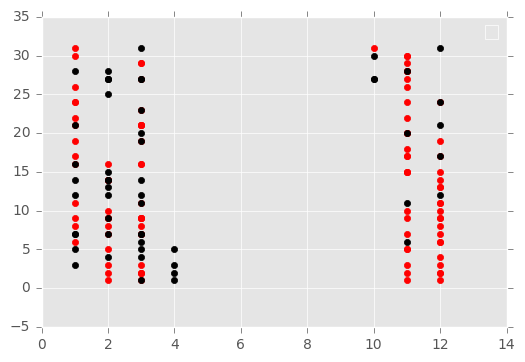

In [639]:
plt.scatter(X_df[X_df["color"] == 1]["mon"], X_df[X_df["color"] == 1]["day"],color="red", label="1:0")
plt.scatter(X_df[X_df["color"] == 0]["mon"], X_df[X_df["color"] == 0]["day"],color="black" , label="0:1")
plt.legend([])

/Users/wyappff/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


<bound method BaseForest.decision_path of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=750, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)>

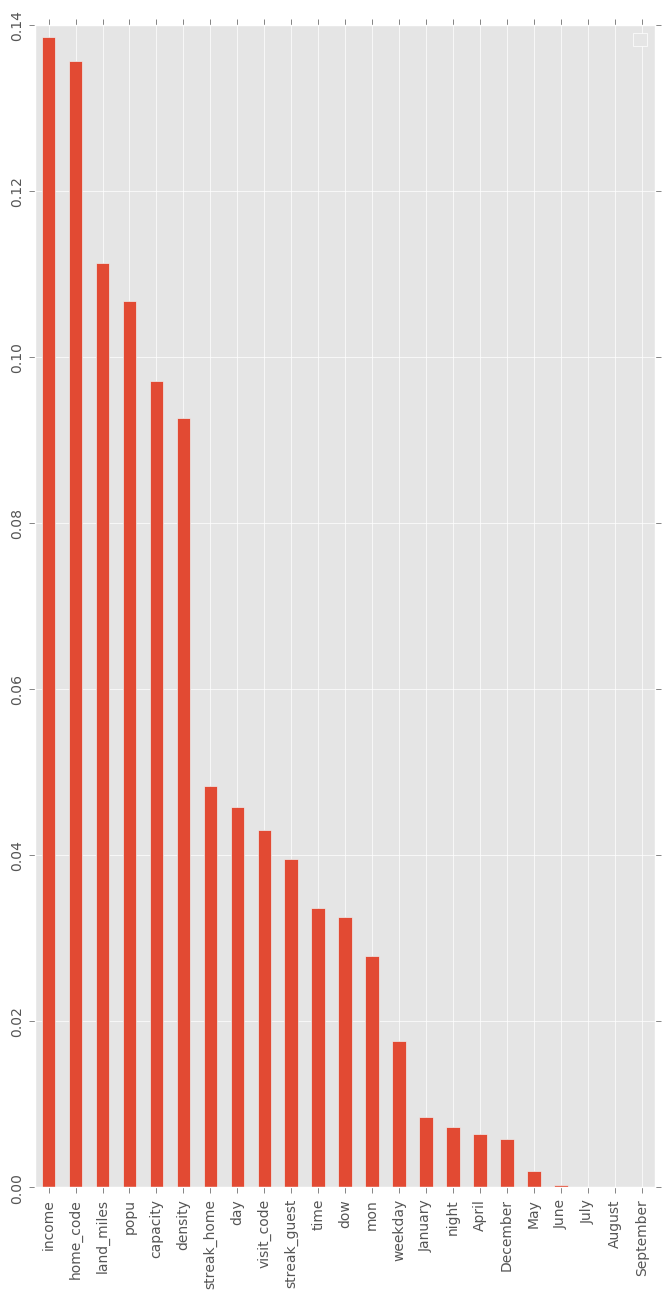

In [640]:
feature_importance = cv_rf.best_estimator_.feature_importances_
features = np.array(Xtrain.columns)
indices = np.argsort(feature_importance)[::-1]

df_ = pd.DataFrame(np.c_[features, feature_importance], columns=["featuers", "importance"])
df_["importance"] = pd.to_numeric(df_["importance"])

df_.sort("importance", ascending=False).reset_index(drop=True).plot(kind="bar", figsize=(8, 15))
plt.xticks(range(len(df_)), features[indices])
plt.yticks(rotation=90)
plt.legend([])
plt.savefig("importance.png", dpi=400, bbox_inches='tight')

cv_rf.best_estimator_.decision_path

In [641]:
from sklearn.externals.six import StringIO
from sklearn import tree
from IPython.display import Image
import pydotplus
from graphviz import Digraph
dot = Digraph(comment='The Round Table')

In [642]:
tf = DTC(max_depth=10, max_features="sqrt",
         min_samples_split=2, min_samples_leaf=1,
         min_weight_fraction_leaf=0.0).fit(Xtrain, y_train)

In [643]:
dot_data = StringIO()
tree.export_graphviz(tf, out_file="tree.dot",
                     feature_names=features,
                     class_names=["Not full", "Crowded"],
                     filled=True, rounded=True,
                     special_characters=True)